In [1]:
from citylearn import  CityLearn
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

In [2]:
# Select the climate zone and load environment
climate_zone = 1
data_path = Path("data/Climate_Zone_"+str(climate_zone))
building_attributes = data_path / 'building_attributes.json'
weather_file = data_path / 'weather_data.csv'
solar_profile = data_path / 'solar_generation_1kW.csv'
building_state_actions = 'buildings_state_action_space.json'
building_ids = ["Building_1","Building_2","Building_3","Building_4","Building_5","Building_6","Building_7","Building_8","Building_9"]
objective_function = ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption']
env = CityLearn(data_path, building_attributes, weather_file, solar_profile, building_ids, buildings_states_actions = building_state_actions, cost_function = objective_function)

observations_spaces, actions_spaces = env.get_state_action_spaces()

In [3]:
# Simulation without energy storage
env.reset()
done = False
while not done:
    _, rewards, done, _ = env.step([[0 for _ in range(len(actions_spaces[i].sample()))] for i in range(len(building_ids))])
cost_no_es = env.cost()

In [4]:
cost_no_es # costs from CityLearn with no Energy Storage

{'ramping': 0.8204563622351975,
 '1-load_factor': 1.012742383473021,
 'average_daily_peak': 0.9872591638228864,
 'peak_demand': 1.1648131161807351,
 'net_electricity_consumption': 1.01405232383894,
 'total': 0.999864669910156}

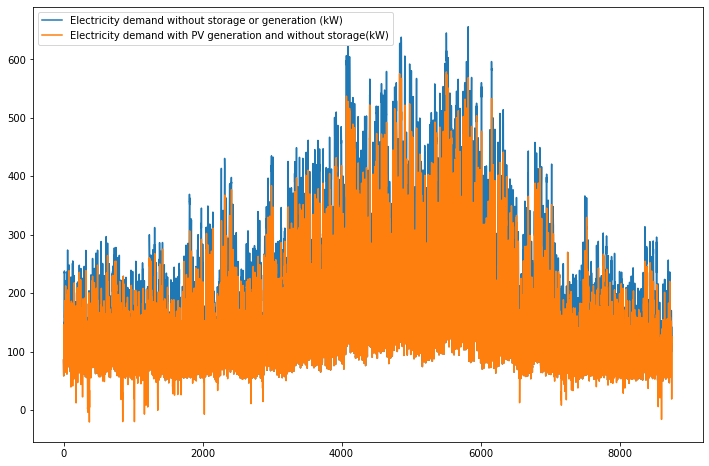

In [5]:
interval = range(0,8759)
plt.figure(figsize=(12,8))
plt.plot(env.net_electric_consumption[interval]+env.electric_generation[interval]-env.electric_consumption_cooling_storage[interval]-env.electric_consumption_dhw_storage[interval])
plt.plot(env.net_electric_consumption[interval]-env.electric_consumption_cooling_storage[interval]-env.electric_consumption_dhw_storage[interval])
plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)'])

In [6]:
# RULE-BASED CONTROLLER (RBC) (Stores energy at night and releases it during the day)
# In this example, each building has its own RBC, which tries to flatten a generic building load 
# by storing energy at night and using it during the day, which isn't necessarily the best solution 
# in order to flatten the total load of the district.

from agent import RBC_Agent

'''IMPORTANT: Make sure that the buildings_state_action_space.json file contains the hour of day as 3rd true state:
{"Building_1": {
    "states": {
        "month": true,
        "day": true,
        "hour": true
Alternative, modify the line: "hour_day = states[0][2]" of the RBC_Agent Class in agent.py
'''

# Instantiatiing the control agent(s)
agents = RBC_Agent(actions_spaces)

state = env.reset()
done = False
rewards_list = []
while not done:
    action = agents.select_action(state)
    next_state, rewards, done, _ = env.step(action)
    state = next_state
    rewards_list.append(rewards)
cost_rbc = env.cost()

In [7]:
cost_rbc

{'ramping': 1.0,
 '1-load_factor': 1.0,
 'average_daily_peak': 1.0,
 'peak_demand': 1.0,
 'net_electricity_consumption': 1.0,
 'total': 1.0}

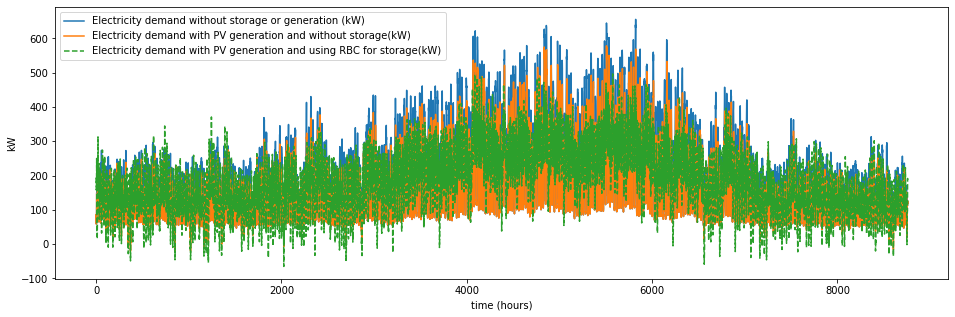

In [8]:
# Plotting winter operation
interval = range(0,8759)
plt.figure(figsize=(16,5))
plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
plt.plot(env.net_electric_consumption_no_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)', 'Electricity demand with PV generation and using RBC for storage(kW)'])

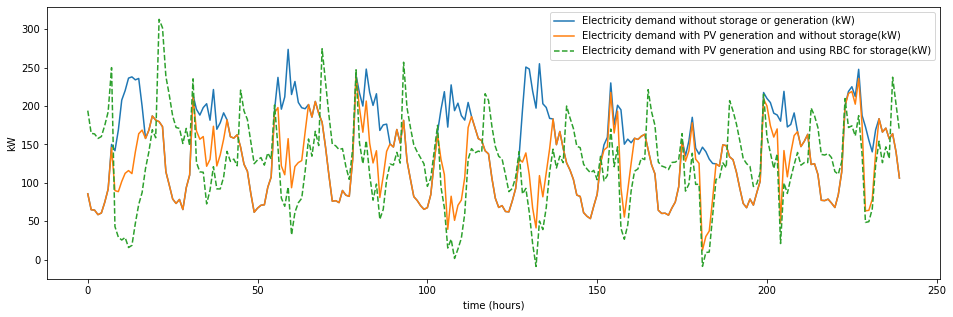

In [9]:
# Plotting winter operation
interval = range(0,24*10)
plt.figure(figsize=(16,5))
plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
plt.plot(env.net_electric_consumption_no_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)', 'Electricity demand with PV generation and using RBC for storage(kW)'])

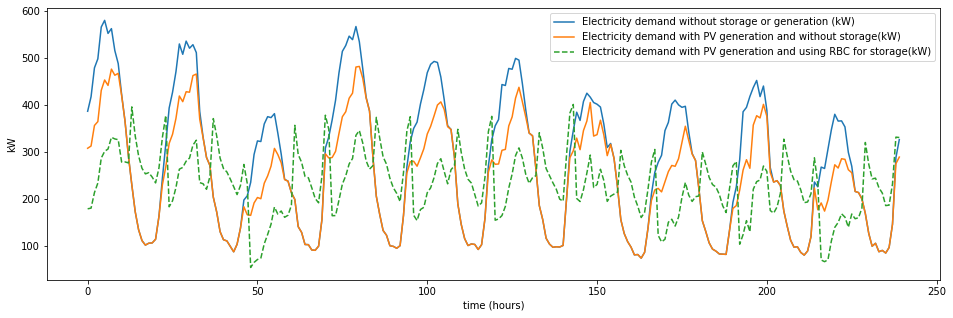

In [10]:
# Plotting summer operation
interval = range(5000,5000 + 24*10)
plt.figure(figsize=(16,5))
plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
plt.plot(env.net_electric_consumption_no_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)', 'Electricity demand with PV generation and using RBC for storage(kW)'])

In [ ]:
# For just one building

In [11]:
# Select the climate zone and load environment
climate_zone = 1
data_path = Path("data/Climate_Zone_"+str(climate_zone))
building_attributes = data_path / 'building_attributes.json'
weather_file = data_path / 'weather_data.csv'
solar_profile = data_path / 'solar_generation_1kW.csv'
building_state_actions = 'buildings_state_action_space.json'
building_ids = ["Building_1"] #,"Building_2","Building_3","Building_4","Building_5","Building_6","Building_7","Building_8","Building_9"]
objective_function = ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption']
env = CityLearn(data_path, building_attributes, weather_file, solar_profile, building_ids, buildings_states_actions = building_state_actions, cost_function = objective_function)

observations_spaces, actions_spaces = env.get_state_action_spaces()

In [14]:
from agent import RBC_Agent

# Instantiatiing the control agent(s)
agents = RBC_Agent(actions_spaces)

state = env.reset()
done = False
rewards_list = []
while not done:
    action = agents.select_action(state)
    next_state, rewards, done, _ = env.step(action)
    state = next_state
    rewards_list.append(rewards)
cost_rbc = env.cost()

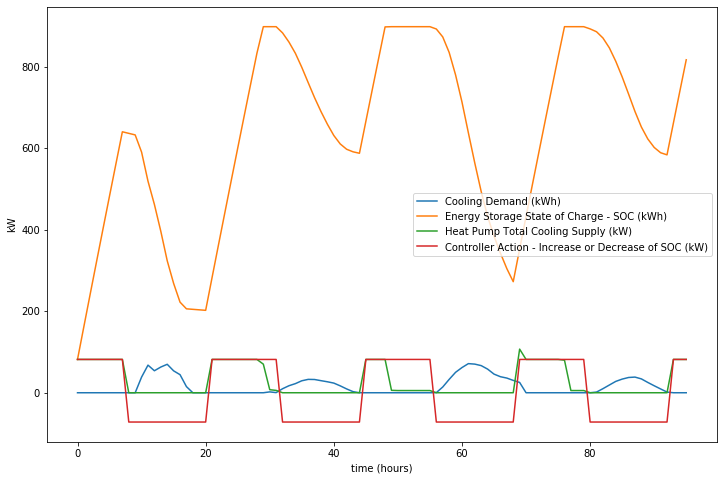

In [15]:
# Plot for one building of the total cooling supply, the state of charge, and the actions of the controller
plt.figure(figsize=(12,8))
building_number = 0 # from 0 to 8
interval = (0,24*4)
plt.plot(env.buildings[building_number].sim_results['cooling_demand'][interval[0]:interval[1]].to_numpy())
plt.plot(env.buildings[building_number].cooling_storage.soc_list[interval[0]:interval[1]])
plt.plot(env.buildings[building_number].cooling_device.cooling_supply[interval[0]:interval[1]])
plt.plot([k[0][0]*env.buildings[building_number].cooling_storage.capacity for k in [j for j in agents.action_tracker[interval[0]:interval[1]]]])
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Cooling Demand (kWh)','Energy Storage State of Charge - SOC (kWh)', 'Heat Pump Total Cooling Supply (kW)', 'Controller Action - Increase or Decrease of SOC (kW)'])

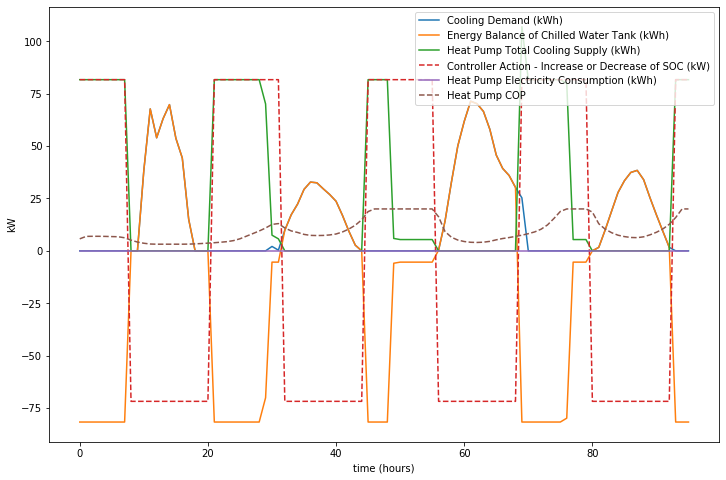

In [16]:
plt.figure(figsize=(12,8))
building_number = 0 # from 0 to 8
interval = (0,24*4)
plt.plot(env.buildings[building_number].sim_results['cooling_demand'][interval[0]:interval[1]].to_numpy())
plt.plot(-np.array(env.buildings[building_number].cooling_storage.energy_balance_list[interval[0]:interval[1]]))
plt.plot(env.buildings[building_number].cooling_device.cooling_supply[interval[0]:interval[1]])
plt.plot([k[0][0]*env.buildings[building_number].cooling_storage.capacity for k in [j for j in agents.action_tracker[interval[0]:interval[1]]]],'--')
plt.plot(env.electric_consumption_cooling[interval[0]:48*2])
plt.plot(env.buildings[building_number].cooling_device.cop_cooling_list[interval[0]:interval[1]],'--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Cooling Demand (kWh)','Energy Balance of Chilled Water Tank (kWh)', 'Heat Pump Total Cooling Supply (kWh)', 'Controller Action - Increase or Decrease of SOC (kW)', 'Heat Pump Electricity Consumption (kWh)','Heat Pump COP'])

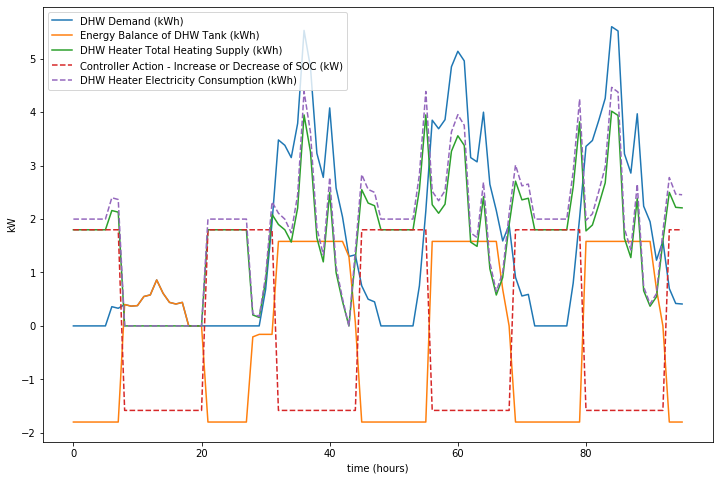

In [26]:
plt.figure(figsize=(12,8))
building_number = 0 # from 0 to 8
interval = (0,24*4)
plt.plot(env.buildings[building_number].sim_results['dhw_demand'][interval[0]:interval[1]].to_numpy())
plt.plot(-np.array(env.buildings[building_number].dhw_storage.energy_balance_list[interval[0]:interval[1]]))
plt.plot(env.buildings[building_number].dhw_heating_device.heat_supply[interval[0]:interval[1]])
plt.plot([k[0][1]*env.buildings[building_number].dhw_storage.capacity for k in [j for j in agents.action_tracker[interval[0]:interval[1]]]],'--')
plt.plot(env.electric_consumption_dhw[interval[0]:48*2],'--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['DHW Demand (kWh)','Energy Balance of DHW Tank (kWh)', 'DHW Heater Total Heating Supply (kWh)', 'Controller Action - Increase or Decrease of SOC (kW)', 'DHW Heater Electricity Consumption (kWh)'])